# Introduction to atomman: Running LAMMPS and the Log class

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 

## 1. Introduction

This Notebook outlines the options of the atomman.lammps.Log class and the atomman.lammps.run() function.

**Library Imports**

In [1]:
# Standard libraries
from __future__ import (absolute_import, print_function,
                        division, unicode_literals)
import os
import glob
import time
import datetime

# http://matplotlib.org/
import matplotlib.pyplot as plt
%matplotlib inline

# https://github.com/usnistgov/atomman
import atomman as am            
import atomman.lammps as lmp
import atomman.unitconvert as uc

# Show atomman version
print('atomman version =', am.__version__)

# Show date of Notebook execution
print('Notebook executed on', datetime.date.today())

atomman version = 1.2.8
Notebook executed on 2019-07-30


## 2. Running LAMMPS

The LAMMPS simulation can be ran from within Python using the run() function.  This runs LAMMPS as a subprocess, meaning that it can use any installed LAMMPS and MPI executables.

Parameters

- **lammps_command** (*str*) The LAMMPS inline run command (sans -in script_name).

- **script_name** (*str*) Path of the LAMMPS input script to use.

- **mpi_command** (*str or None, optional*) The MPI inline command to run LAMMPS in parallel. Default value is None (no mpi).

- **restart_script_name** (*str or None, optional*) Alternative script to use for restarting if logfile already exists.  Default value is None (no restarting).

- **return_style** (*str, optional*) The format for the returned data. Default value is 'object'.

    - 'object' -- returns an atomman.lammps.Log object.
    
    - 'model' -- returns a DataModelDict.
    
- **logfile** (*str, optional*) Specifies the path to the logfile to write to.  Default value is 'log.lammps'.

- **flatten** (*str or None, optional*) Specifies if the simulations are to be flattened, and which flatten style to use:
    
    - None does not flatten the simulations (default).
    
    - 'first' uses the values from the earliest simulation.
    
    - 'last' uses the values from the latest simulation.

Returns

- (*atomman.lammps.Log*) An object representation of the log.lammps file.

Create a simple demonstration LAMMPS input script

In [2]:
with open('demo.in', 'w') as f:
    f.write("""
#Simple demonstration LAMMPS script

units metal
atom_style atomic
boundary p p p 

lattice fcc 3.52 origin 0.100000 0.100000 0.100000 
        
region box block 0 15 0 15 0 15
create_box 1 box
create_atoms 1 box

mass 1 58.71

pair_style lj/cut 6
pair_coeff 1 1 0.5408 2.272

velocity all create 100 2987532

thermo 100
thermo_style custom step pe temp press lx ly lz

restart 10000 *.restart

timestep 0.01

fix 1 all npt temp 100 100 1.0 aniso 0.0 0.0 10.0
run 10000

""")

Run in serial

In [3]:
# Define lammps command to use (unique to your computer!)
lammps_command = 'lmp_mpi'

# Run and measure execution time
start = time.time()
results = lmp.run(lammps_command, 'demo.in')
end = time.time()
run_time = end-start

print("Serial simulation took", run_time, "seconds.")

Serial simulation took 97.33864641189575 seconds.


Run in parallel on 4 processors

In [4]:
# Define lammps command to use (unique to your computer!)
lammps_command = 'lmp_mpi'

# Define mpi command to use (unique to your computer!)
mpi_command = 'C:\\Program Files\\MPICH2\\bin\\mpiexec.exe -localonly 4'

# Run and measure execution time
start = time.time()
results = lmp.run(lammps_command, 'demo.in', mpi_command=mpi_command)
end = time.time()
run_time = end-start

print("Parallel simulation took", run_time, "seconds.")

Parallel simulation took 52.03832960128784 seconds.


## 3. Accessing results with Log class

Information from the log.lammps file(s) is automatically parsed by the run() function and returned as an atomman.lammps.Log object.  Currently, the Log class stores the following information:

- **lammps_version** (*str*) The LAMMPS version used.

- **lammps_date** (*datetime.date*) The date associated with the LAMMPS version.

- **simulations** (*list of dict*) information for each simulation (run, minimize ...) that was executed.
    
Each simulation dictionary contains the following keys:
    
- **thermo** (*pandas.DataFrame*) The thermo data for each simulation.

In [5]:
print("results.lammps_version ->", results.lammps_version)
print("results.lammps_date ->", results.lammps_date)

results.lammps_version -> 5 Jun 2019
results.lammps_date -> 2019-06-05


In [6]:
results.simulations[0]['thermo'].keys()

Index(['Step', 'PotEng', 'Temp', 'Press', 'Lx', 'Ly', 'Lz'], dtype='object')

This makes it very easy to plot the simulation thermo data

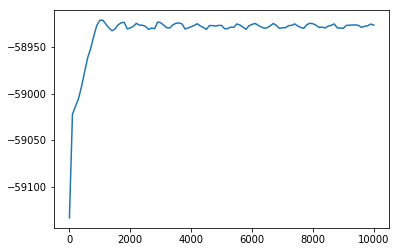

In [7]:
for simulation in results.simulations:
    plt.plot(simulation['thermo'].Step, simulation['thermo'].PotEng)
    plt.show()

## 4. Restarting and flattening

There is also some built-in functionality for conveniently handling simulations containing multiple runs and/or multiple sequential simulation executions of the same overall run (i.e. restarts).

### 4.1 Running with restart script included

Create a new demonstration LAMMPS input script that restarts the previous simulation and runs for an additional 10000 steps.

In [8]:
with open('demo_restart.in', 'w') as f:
    f.write("""
#Simple demonstration LAMMPS restart script

read_restart *.restart

mass 1 58.71

pair_style lj/cut 6
pair_coeff 1 1 0.5408 2.272

thermo 100
thermo_style custom step pe temp press lx ly lz

restart 10000 *.restart

fix 1 all npt temp 100 100 1.0 aniso 0.0 0.0 10.0
run 10000

""")

Now, if we call run() with the restart_script_name parameter set, a number of cool things happen:

- If logfile (default log.lammps) does not exist in the working directory then the 'demo.in' script is passed to LAMMPS.

- If logfile does exist then it is moved from NAME.EXT to NAME-\*.EXT, where \* is the smallest integer not already there, and the 'demo_restart.in' script is passed to LAMMPS.

- Upon completion, the data in NAME.EXT logfile and all NAME-\*.EXT logfiles are automatically read in by the Log object.

In [9]:
results = lmp.run(lammps_command, 'demo.in', mpi_command=mpi_command,
                  restart_script_name='demo_restart.in')

Show all log files in the run directory

In [10]:
for logfile in glob.iglob('*.lammps'):
    print(logfile)

log-1.lammps
log.lammps


Show that results now has two simulations, one for steps 0 to 10000 and one for steps 10000 to 20000 (the restart)

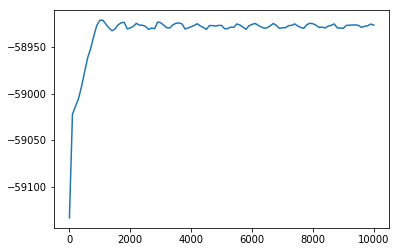

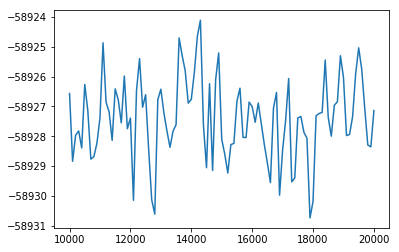

In [11]:
for simulation in results.simulations:
    plt.plot(simulation['thermo'].Step, simulation['thermo'].PotEng)
    plt.show()

### 4.2. Flattening data from multiple simulations together

Multiple simulations also occurs if one simulation script contains more than one run or minimize commands. If you want to compress all of the data to one simulation record, you can use the Log.flatten() method.

Parameters

- **style** (*str, optional*) Flattening removes rows with duplicate Step values, and style specifies which values are kept/removed.  The 'last' style (default) keeps the values from the last simulation that they appear in, while the 'first' style keeps the values from the first simulation that they appear in. 

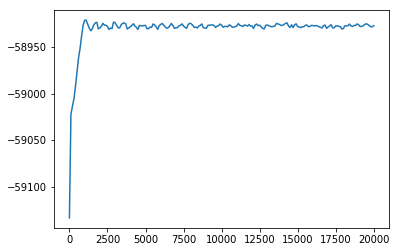

In [12]:
results.flatten()

for simulation in results.simulations:
    plt.plot(simulation['thermo'].Step, simulation['thermo'].PotEng)
    plt.show()

The run() function also has a flatten parameter which will automatically flatten the data after reading it in.

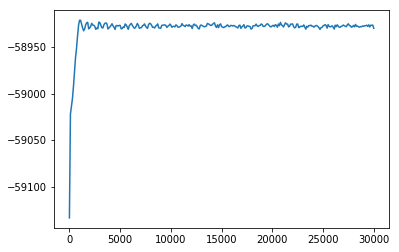

In [13]:
# rerun again, this time with the flatten='last' option
results = lmp.run(lammps_command, 'demo.in', mpi_command=mpi_command,
                  restart_script_name='demo_restart.in', flatten='last')

for simulation in results.simulations:
    plt.plot(simulation['thermo'].Step, simulation['thermo'].PotEng)
    plt.show()

**File Cleanup**

In [14]:
os.remove('demo.in')
os.remove('demo_restart.in')
os.remove('log.lammps')
for restart in glob.iglob('*.restart'):
    os.remove(restart)
for restart in glob.iglob('log-*.lammps'):
    os.remove(restart)